In [0]:
%tensorflow_version 1.x
import os
import tarfile
import shutil
import time

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
!pip install bert-tensorflow
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle


tf.logging.set_verbosity(tf.logging.ERROR)

OUTPUT_DIR = 'tmp1'

gpt2.mount_gdrive()

gpt2.copy_file_from_gdrive("bert_gan_real.csv")

real = pd.read_csv('bert_gan_real.csv')
fakes = []
for i in ["100", "200", "400", "600", "800"]:
  gpt2.copy_file_from_gdrive(f"bert_gan_fake{i}.csv")
  fakes.append(pd.read_csv(f"bert_gan_fake{i}.csv"))
fake = pd.concat(fakes)
fake['reply']=fake['reply'].astype(str)
fake['real']=0
df = pd.concat([real,fake])[['comment','reply','real']].dropna()


INPUT_COLUMN = 'comment'
DATA_COLUMN = 'reply'
LABEL_COLUMN = 'real'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

train, test = train_test_split(df, test_size=0.1)

# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[INPUT_COLUMN], 
                                                                   text_b = x[DATA_COLUMN], 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[INPUT_COLUMN], 
                                                                   text_b = x[DATA_COLUMN], 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 64
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

def getPrediction(in_sentence_pairs):
  labels = ["Fake", "Real"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x[0], text_b = x[1], label = 0) for x in in_sentence_pairs] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return pd.DataFrame([(sentence[0], sentence[1], np.exp(prediction['probabilities'][1]), labels[prediction['labels']]) for sentence, prediction in zip(in_sentence_pairs, predictions)], columns=['comment', 'reply', 'prob_real','label'])


file_path = 'tuned_BERT_discriminator.tar'
shutil.copyfile("/content/drive/My Drive/" + file_path, file_path)
with tarfile.open(file_path, 'r') as tar:
    tar.extractall()

# print(f'Beginning Training!')
# current_time = datetime.now()
# estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
# print("Training took time ", datetime.now() - current_time)

# file_path = 'tuned_BERT_discriminator_new.tar'
# with tarfile.open(file_path, 'w') as tar:
#     tar.add('tmp1')
# shutil.copyfile(file_path, "/content/drive/My Drive/" + file_path)

estimator.evaluate(input_fn=test_input_fn, steps=None)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'auc': 0.9937462,
 'eval_accuracy': 0.9989755,
 'f1_score': 0.99944645,
 'false_negatives': 1.0,
 'false_positives': 10.0,
 'global_step': 9059,
 'loss': 0.004044493,
 'precision': 0.998994,
 'recall': 0.9998993,
 'true_negatives': 796.0,
 'true_positives': 9930.0}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:255: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


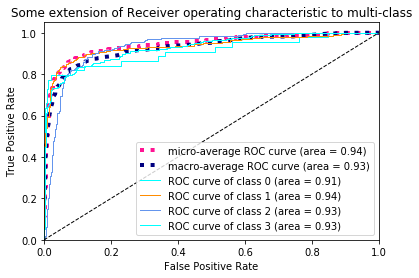

In [0]:
OUTPUT_DIR = 'tmp2'


df = pd.read_csv('bert_gan_real.csv')

INPUT_COLUMN = 'comment'
DATA_COLUMN = 'reply'
LABEL_COLUMN = 'rating'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1, 2, 3]

train, test = train_test_split(df.dropna())

# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[INPUT_COLUMN], 
                                                                   text_b = x[DATA_COLUMN], 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[INPUT_COLUMN], 
                                                                   text_b = x[DATA_COLUMN], 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 5.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator_editor = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

def plot_roc(in_y, in_prob):
  y = label_binarize(in_y, classes=[0, 1, 2, 3])
  n_classes = y.shape[1]
  y_score = np.stack(in_prob.values)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=1,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

def getEditorPrediction(in_sentence_pairs):
  input_examples = [run_classifier.InputExample(guid="", text_a = x[0], text_b = x[1], label = 0) for x in in_sentence_pairs] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator_editor.predict(predict_input_fn)
  return pd.DataFrame([(sentence[0], sentence[1], np.exp(prediction['probabilities']), prediction['labels']) for sentence, prediction in zip(in_sentence_pairs, predictions)], columns=['comment', 'reply', 'prob','label'])

file_path = 'tuned_BERT_editor.tar'
shutil.copyfile("/content/drive/My Drive/" + file_path, file_path)
with tarfile.open(file_path, 'r') as tar:
    tar.extractall()

# print(f'Beginning Training!')
# current_time = datetime.now()
# estimator_editor.train(input_fn=train_input_fn, max_steps=num_train_steps)
# print("Training took time ", datetime.now() - current_time)

# file_path = 'tuned_BERT_editor.tar'
# with tarfile.open(file_path, 'w') as tar:
#     tar.add('tmp2')
# shutil.copyfile(file_path, "/content/drive/My Drive/" + file_path)

real_sent = test.head(1000)[['comment','reply']].values.tolist()
predictions_real = getEditorPrediction(real_sent)
plot_roc(test.head(1000)['rating'], predictions_real['prob'])

In [0]:
date = '2019_02_04'
gpt2.copy_file_from_gdrive(f'proposed_replies_{date}.csv')
proposed_replies = pd.read_csv(f'proposed_replies_{date}.csv').dropna()
replies_to_test = proposed_replies[['comment','proposed_reply']].values.tolist()
predictions_proposed = getPrediction(replies_to_test)
realistic_replies = proposed_replies.drop(['proposed_reply','Unnamed: 0'], axis=1).drop_duplicates().merge(predictions_proposed,on='comment')
realistic_replies.to_csv(f'realistic_replies_{date}.csv')
gpt2.copy_file_to_gdrive(f'realistic_replies_{date}.csv')

In [0]:
only_realistic_replies = realistic_replies.loc[(realistic_replies['prob_real']>0.9) & (realistic_replies['reply'].str.len() < 1000 )  & (realistic_replies['reply'].str.len() < 1000 )]
all_replies_to_test = only_realistic_replies[['comment','reply']].values.tolist()
predictions_proposed_list=[]
for chunk in range(int(len(all_replies_to_test)/32)):
  replies_to_test = all_replies_to_test[chunk*32:chunk*32+32]
  predictions_proposed_list.append(getEditorPrediction(replies_to_test))
predictions_proposed = pd.concat(predictions_proposed_list)
best_predictions = only_realistic_replies.drop(['reply','label'], axis=1).drop_duplicates().merge(predictions_proposed,on='comment')
best_predictions['score']=best_predictions['prob'].apply(lambda x: x[1]+x[2]*2+x[3]*3)

best_predictions.to_csv(f'reply_score_predictions_{date}.csv')
gpt2.copy_file_to_gdrive(f'reply_score_predictions_{date}.csv')

return_table = best_predictions.sort_values('score', ascending=False).groupby('post_id').first()

In [0]:
return_table

,subreddit,title,post_score,comment_id,comment_score,comment,prob_real,reply,prob,label,score
post_id,,,,,,,,,,,
eyeytw,BurningMan,How to Resto track/record MOOP and create a de...,15,fggrw7x,6,hmmm close to when DGS tickets are published t...,0.999960,"I didn't even know you can't use the word ""noi...","[0.00069063785, 0.00028107542, 0.22144413, 0.7...",3,2.775922
eyiqpb,BurningMan,Update on DGS allocations,51,fghos4p,14,"Ooh... reading more closely, a detail I’d miss...",0.999859,The first group of tickets were available to e...,"[0.0002040492, 3.6349673e-05, 0.0067798607, 0....",3,2.992535
eyjk35,sciencefiction,Rick Moranis Reportedly Coming Out of Retireme...,457,fghlp16,78,The world has been waiting for this comeback.,0.999846,"This is a great post. I hope they succeed, oth...","[0.00010059167, 3.0880034e-05, 0.0034596634, 0...",3,2.996177
eynclw,scifi,New 'Star Trek' series 'Section 31' to start f...,831,fgi9jqm,290,"So we get the 3rd version of the same: ""secret...",0.999961,"Or perhaps ""the Borg"" could serve that purpose.","[0.0009765797, 0.0011006269, 0.5675317, 0.4303...",2,2.427337
eyqgop,writing,How to write short stories,344,fgj59x6,16,PulitzerBot is chuckling over the image of you...,0.997861,I don't disagree with PulitzerBot. There are g...,"[0.011143051, 0.01711269, 0.3364254, 0.6353189]",3,2.595920
eysm8e,sciencefiction,Expeditionary Force Trailer (for the audiobook...,50,fgjahpj,4,I don't think I'd like these books without the...,0.999891,This is a great book. I hope they continue to ...,"[5.7368343e-05, 0.0008646791, 0.9984426, 0.000...",2,1.999656
eysqm7,scifi,Things Science Fiction Takes for Granted,18,fgj0lpy,9,">\tPerhaps the 2nd is the most challenging, ar...",0.998846,"I don't think artificial gravity is a trope, p...","[0.0010185558, 0.040964566, 0.9331467, 0.02487...",2,1.981869
eyt26j,scifi,Just started watching Dark Matter on netflix,22,fgj2eqw,5,**Dark Matter** is still my favorite space-bas...,0.999693,I still can't figure out who's favorite charac...,"[4.875186e-05, 0.0006346434, 0.99838746, 0.000...",2,2.000197
eyx7ut,sciencefiction,The expanse,85,fgjzvzp,4,The Red Rising series is fantastic! Highly rec...,0.996800,&gt;The Red Rising series is fantastic! Highly...,"[0.012537212, 0.031186005, 0.010771686, 0.9455...",3,2.889245


In [0]:
!pip install praw
import praw
reddit = praw.Reddit(client_id='client_id', 
                     client_secret='client_secret',
                     password='reddit_password',
                     username='reddit_username',
                     user_agent='reddit API user agent')

     |████████████████████████████████| 143kB 2.8MB/s 
     |████████████████████████████████| 204kB 64.2MB/s 


In [0]:
for idx, row in return_table.iterrows():
  c = reddit.comment(id=row['comment_id'])
  c.refresh()
  already_applied = any([r.author == 'tupperware-party' for r in c.replies])
  print("----------------------------------")
  if not already_applied:
    print(c.body)
    if c.body!='[deleted]':
      print(f"REPLYING NOW WITH: {row['reply']}")
      c.reply(row['reply'])
      time.sleep(60+np.random.random()*60*10)
    else:
      print('that was deleted anyway\n')
     
  else:
    print('ALREADY REPLIED TO THAT ONE\n')
  print("----------------------------------\n\n")

----------------------------------
hmmm close to when DGS tickets are published to camps.... no final high res MOOP map released this year...  A leading question from soomeone on how resto tracks/records MOOP....

Did someone get a naughty letter from the Org?
REPLYING NOW WITH: I didn't even know you can't use the word "noisy", I just thought it was used a lot.
----------------------------------


----------------------------------
Ooh... reading more closely, a detail I’d missed: looks like that second group of DGS tickets will be available to *new* camps as well as existing ones.
REPLYING NOW WITH: The first group of tickets were available to existing camps as well as people who already had been through DGS, and so were not necessarily the biggest groups.
----------------------------------


----------------------------------
The world has been waiting for this comeback.
REPLYING NOW WITH: This is a great post. I hope they succeed, otherwise it's gonna be a long time until the next 